In [ ]:
#!/usr/bin/env python3.7
# coding: utf-8

In[1]:

Imports for the Maptek Python SDK and additional libraries.

In [79]:
import collections
import copy
import ctypes
import fractions
import json
import math
import sys
import time
from collections import defaultdict
from itertools import islice

import matplotlib as mpl
import matplotlib.colors as cc
import matplotlib.pyplot as cm
import numpy as np
import pandas as pd
import seaborn as sns
from mapteksdk.data import (
    DenseBlockModel,
    GridSurface,
    NumericColourMap,
    SubblockedBlockModel,
    Surface,
    Text3D,
)
from mapteksdk.project import Project
from matplotlib.ticker import PercentFormatter
from matplotlib.widgets import Button, CheckButtons, RadioButtons
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from tqdm import tqdm_gui
from tqdm.notebook import tqdm, trange

# mpl.use('agg')


cm.rcParams["font.family"] = ["Source Han Sans TW", "monospace"]
cm.rcParams["font.size"] = 14

# Connect to the currently running Maptek Project.

project = Project()
# project.mcp_instance.mcp_dict['PRODUCT_LOCATION_INFO']  # Report out which application it connected to (Optional)

In [80]:
# In[2]:

# Initialisation

selected_model = None
selected_var = ""
colours = ""
real_colours = []
vis = ""
# ****************Bool switches for certain features*****************************************************************
vis_compiler = False
point_checker = True
# ********************************************************************************************************************
names = []
df = pd.DataFrame()
selection = project.get_selected()
last_opacity = 255

global M
M = len(selection)
vis_collection = [0] * M
var_collection = [0] * M
index_map = [0] * M
extents = [[] for _ in range(M)]
# i tells you the index of the block_model
i = 0
j = 0

for name_iterator in selection:
    block_model_name = name_iterator.name
    if (
        name_iterator.is_a(DenseBlockModel) == False
        and name_iterator.is_a(SubblockedBlockModel) == False
    ):
        print("Please select a Block Model to compare, Try Again.")
        time.sleep(3)
        sys.exit()

if len(selection) < 1:
    print("Please select a Block Model to compare, Try Again.")
    time.sleep(3)
    sys.exit()
elif len(selection) > 1:
    print("Please select only one Block Model to compare with the points, Try Again")
    time.sleep(3)
    sys.exit()

point_location = input(
    "Put in the exact location of PointSet you want to compare (ex:samples/PointSet ) : "
)

# DATA GETTER

for item in selection:
    print("The name of the Block Model you have selected: " + str(item.name))
    # Setting outer array back to 0, for new block
    j = 0
    nn = 0
    if item.is_a(DenseBlockModel) or item.is_a(SubblockedBlockModel):
        selected_model = item
        # Checker for point stuff
        if point_checker:
            # Getting all block details
            with project.edit(selected_model) as bm:
                block_sizes = bm.block_sizes
                block_centroids = bm.block_centroids
                b = bm.block_resolution
                x_res = float(b[0])
                y_res = float(b[1])
                z_res = float(b[2])
                x_count = bm.column_count
                y_count = bm.row_count
                z_count = bm.slice_count
                totallength_x_dimension = x_res * x_count
                totallength_y_dimension = y_res * y_count
                totallength_z_dimension = z_res * z_count
                print(
                    totallength_x_dimension,
                    totallength_y_dimension,
                    totallength_z_dimension,
                )
                index_map[i] = bm.block_to_grid_index
                # index_map[i] = index_map[i].tolist()
                number_of_parent_blocks = len(np.unique(index_map[i], axis=0))
                total_volume_of_block = number_of_parent_blocks * x_res * y_res * z_res
                # ****************************************************************
                # * This the better fast method.
                temp_dict_for_storing = {}
                for block, grid_index in tqdm(
                    enumerate(index_map[i]),
                    total=len(index_map[i]),
                    desc="Progress",
                    ncols=100,
                    ascii=True,
                    position=0,
                    leave=True,
                ):
                    # We want to use the grid_index as the dictionary key. It needs to
                    # be converted to a tuple which can be hashed.
                    # Also, the grid_index is returned from the SDK as a float array
                    # which seems odd. So convert to an integer array as well.
                    grid_index_tuple = tuple(grid_index.astype(int))
                    if grid_index_tuple in temp_dict_for_storing:
                        temp_dict_for_storing[grid_index_tuple].append(block)
                    else:
                        temp_dict_for_storing[grid_index_tuple] = [block]
                print(
                    "Number of parent blocks for this block model: "
                    + str(len(temp_dict_for_storing))
                )
                reverse_grid_index = temp_dict_for_storing
                # **********************************************************************************************
                # Converting from world coordinates
                block_centroids = bm.convert_to_block_coordinates(block_centroids)
                block_centroids = block_centroids + 0.5 * np.array(
                    [x_res, y_res, z_res]
                )
                # Getting sample point data for point to block comparison
                with project.read(point_location) as points:
                    # SDK method
                    real_points = points.points
                    point_visibility = points.point_visibility
                    real_points = bm.convert_to_block_coordinates(real_points)
                    real_points = real_points + (np.array([x_res, y_res, z_res]) / 2)
                    point_collection = [0] * len(real_points)
                    point_domains_names = points.point_attributes.names
                    for dictionary in point_domains_names:
                        if (
                            json.loads(dictionary)["c"] == "Domain"
                            or json.loads(dictionary)["c"] == "domain"
                            or json.loads(dictionary)["c"] == "geocod"
                        ):
                            point_domain_dict = str(dictionary)
                    point_domains = points.point_attributes[point_domain_dict]
                # *************************************************************************************************
                # Brute-force method
                print("Calculating block extents....")
                for nn, useless_var in tqdm(
                    enumerate(block_centroids),
                    total=len(block_centroids),
                    desc="Progress",
                    ncols=100,
                    ascii=True,
                    position=0,
                    leave=True,
                ):
                    # print(len(extents[0]))
                    # print(len(extents[1]))
                    extents[i].append(
                        (
                            [
                                np.round((block_centroids[nn] - block_sizes[nn] / 2),6).tolist(),
                                np.round((block_centroids[nn] + block_sizes[nn] / 2),6).tolist(),
                            ]
                        )
                    )
                # *************************************************************************************************
                # # Checks all attributes of block and then chooses the one with discrete values
                a_dict = bm.block_attributes.names
                for key in a_dict:
                    checker = bm.block_attributes[key]
                    if isinstance(checker[0], (str, int)):
                        selected_var = checker
                        var_collection[i] = selected_var
                vis = bm.block_visibility
                vis_collection[i] = vis
                i = i + 1

Put in the exact location of PointSet you want to compare (ex:samples/PointSet ) :  samples/assay_data


The name of the Block Model you have selected: Big royhill 9-2-2022 17:55
9547.5 32490.0 267.5


Progress:   0%|                                                         | 0/8583501 [00:00<?, ?it/s]

Number of parent blocks for this block model: 7355394
Calculating block extents....


Progress:   0%|                                                         | 0/8583501 [00:00<?, ?it/s]

POINT TO BLOCK/SUB-BLOCK COMPARISON

In [81]:
point_pos1 = {}
points_that_dont_match = []
points_that_match = []
domains_of_blocks = []
outside_count = 0
subblock_exists = 0
outside_indices = []
point_in_sublock = []
lengths_of_subblock_indices = []
test_array=[False]*len(real_points)
number_of_checks_happening_per_block = []
samplepoints_crawler = 0
check = 0
pointnotfound_in_indices_givenbygridindex = []
with project.read(selected_model) as bm:
    for samplepoints_crawler, samplepoints_value in tqdm(
        enumerate(real_points),
        total=len(real_points),
        desc="Progress",
        ncols=100,
        ascii=True,
        position=0,
        leave=True,
    ):
        c1 = math.floor(samplepoints_value[0] / x_res)
        c2 = math.floor(samplepoints_value[1] / y_res)
        c3 = math.floor(samplepoints_value[2] / z_res)

        # if (0 <= c1 < x_count) and (0 <= c2 < y_count) and (0 <= c3 < z_count):
        subblock_indices = reverse_grid_index.get((c1, c2, c3))
        if (subblock_indices) is not None:
            subblock_exists += 1
            for ex in subblock_indices:
                check += 1
                if (
                    (
                        extents[0][ex][0][0]
                        <= samplepoints_value[0]
                        <= extents[0][ex][1][0]
                    )
                    and (
                        extents[0][ex][0][1]
                        <= samplepoints_value[1]
                        <= extents[0][ex][1][1]
                    )
                    and (
                        extents[0][ex][0][2]
                        <= samplepoints_value[2]
                        <= extents[0][ex][1][2]
                    )
                ):
                    number_of_checks_happening_per_block.append(
                        (check, samplepoints_crawler)
                    )
                    check = 0
                    point_in_sublock.append(ex)
                    point_pos1[samplepoints_crawler] = ex
                    domains_of_blocks.append(selected_var[ex])
                    break
                elif check == len(subblock_indices):
                    print(samplepoints_crawler)
                    print(c1, c2, c3)
                    print(subblock_indices)
                    check = 0
                    pointnotfound_in_indices_givenbygridindex.append(
                        samplepoints_crawler
                    )
        else:
            # print(c1, c2, c3)
            test_array[samplepoints_crawler]=True
            outside_count += 1
            outside_indices.append(samplepoints_crawler)
            continue

Progress:   0%|                                                          | 0/681686 [00:00<?, ?it/s]

In [68]:
np.where(test_array)

(array([   157,    158,  16093,  92264, 101841, 115086], dtype=int64),)

In [82]:
point_to_be_deleted_before_check = outside_indices
point_domains = [z.lower() for z in point_domains]
point_domains_wo_outliers = []

point_domains_wo_outliers = copy.deepcopy(point_domains)
point_domains_wo_outliers = np.delete(
    point_domains_wo_outliers, point_to_be_deleted_before_check
)

# This loop below is basically for finding how many blocks match or not, we are storing the indexes for<br>
# getting their positions in the list where outsiders are already cut out

for points_index, (x, y) in enumerate(
    zip(point_domains_wo_outliers, domains_of_blocks)
):
    if x == y:
        points_that_match.append(points_index)
    else:
        points_that_dont_match.append(points_index)

# For getting positions of points which dont match with the blocks they are positioned in

point_pos_which_dont_match = copy.deepcopy(list(point_pos1.values()))
# Deleting all values which are matching, hencing leaving us with the positions where there is no matching
point_pos_which_dont_match = np.delete(point_pos_which_dont_match, points_that_match)

In [83]:
print(point_to_be_deleted_before_check)

[137918, 137919, 137920, 137921, 137922, 139736, 139737, 139738, 139739, 139740, 139741, 139742, 139743, 139744, 139745, 139746, 139747, 139748, 139749, 139750, 139751, 139752, 139753, 139754, 139755, 139756, 139757, 139758, 139759, 139760, 139761, 139762, 139763, 139764, 139765, 139766, 139767, 139768, 139769, 139770, 158306, 158307, 158308, 158309, 158310, 158311, 158312, 158313, 158314, 158315, 158316, 158317, 158318, 158319, 158320, 158321, 158322, 158323, 158324, 158325, 158326, 158327, 158328, 158329]


In [84]:
print("*******************")
print("*******************")
print("Number of points which do not match: " + str(len(points_that_dont_match)))
print("Number of points which match:: " + str(len(points_that_match)))
print("**********************************************************")

*******************
*******************
Number of points which do not match: 130038
Number of points which match:: 551584
**********************************************************


In [85]:
print("Number of points which are outside the model: " + str(outside_count))
print("*******************")

Number of points which are outside the model: 64
*******************


In [86]:
print("*******************")
print(
    "points not found inside block indices given by grid_index and their total number:"
)
print(pointnotfound_in_indices_givenbygridindex)
print(len(pointnotfound_in_indices_givenbygridindex))

*******************
points not found inside block indices given by grid_index and their total number:
[]
0


In [87]:
point_domains_wo_outliers[pointnotfound_in_indices_givenbygridindex]

array([], dtype='<U5')

STATISTICAL REPORT

In [88]:
df2 = pd.DataFrame()

match_percentage = str(
    round(((len(points_that_match) * 100) / len(point_domains_wo_outliers)), 2)
)

print(
    "From "
    + str(len(point_domains_wo_outliers))
    + " points (excluding "
    + str((outside_count))
    + " outliers, which were outside the block model) "
    + str(len(points_that_match))
    + " points were in the same block with the same domain"
    + " hence having a match percentage of "
    + match_percentage
)

print("The number of unique points:" + str(len(point_domains_wo_outliers)))
print("The number of unique blocks:" + str(len(set(list(point_pos1.values())))))

# print(len(point_domains_wo_outliers))
# print(len(domains_of_blocks))

df2["Points Domain"] = pd.Series(point_domains_wo_outliers)
df2["Block Domains"] = pd.Series(domains_of_blocks)

print(1 * "\n")
print("Domain distribution in SAMPLE:")

(point_domain_names, domain_frequencies) = np.unique(
    point_domains_wo_outliers, return_counts=True
)
(block_domain_names, block_domain_frequencies) = np.unique(
    domains_of_blocks, return_counts=True
)

print(df2["Points Domain"].value_counts())
for x, y in zip(point_domain_names, domain_frequencies):
    print(
        str(x)
        + ": "
        + str(round((y * 100) / (len(point_domains_wo_outliers)), 2))
        + " %"
    )

print(1 * "\n")
print("Domain distribution in " + str(block_model_name) + ":")
print(df2["Block Domains"].value_counts())
for x, y in zip(block_domain_names, block_domain_frequencies):
    print(
        str(x)
        + ": "
        + str(round((y * 100) / (len(point_domains_wo_outliers)), 2))
        + " %"
    )

From 681622 points (excluding 64 outliers, which were outside the block model) 551584 points were in the same block with the same domain hence having a match percentage of 80.92
The number of unique points:681622
The number of unique blocks:331677


Domain distribution in SAMPLE:
alu      119505
diw      106408
nam      105551
cla       70299
tnam      61085
jer       52907
hnam      45475
onam      40742
sonam     26804
did       26035
mng       16064
cc         9030
dol         816
ns          692
-999        130
sc           67
fill         11
cav           1
Name: Points Domain, dtype: int64
-999: 0.02 %
alu: 17.53 %
cav: 0.0 %
cc: 1.32 %
cla: 10.31 %
did: 3.82 %
diw: 15.61 %
dol: 0.12 %
fill: 0.0 %
hnam: 6.67 %
jer: 7.76 %
mng: 2.36 %
nam: 15.49 %
ns: 0.1 %
onam: 5.98 %
sc: 0.01 %
sonam: 3.93 %
tnam: 8.96 %


Domain distribution in Big royhill 9-2-2022 17:55:
alu      118407
diw      110754
nam      109840
cla       71199
tnam      62639
jer       55021
onam      40260
hnam      3

In [89]:
blockfilter = "No"
print(1 * "\n")
blockfilter = input(
    "Do you want to only see the blocks and points where the PointSet is not matching with the Block Model (Yes/No): "
)

if (blockfilter == "Yes") or (blockfilter == "Y") or (blockfilter == "y"):
    blockfilter = "Yes"
    print(
        "A new container called Filtered_block_and_points conatins the edited Model and Poinset"
    )
    time.sleep(3)

if blockfilter == "Yes":
    project.new_visual_container("/", "Filtered_block_and_points")
    filtered_block = project.copy_object(
        selected_model, "Filtered_block_and_points/Filtered_Block", overwrite=True
    )
    filtered_pointset = project.copy_object(
        point_location, "Filtered_block_and_points/Filtered_PointSet", overwrite=True
    )
    # Only show BLOCKS which dont match their domain
    block_array_of_visibility_created = []
    with project.edit(filtered_block) as bm:
        block_array_of_visibility = bm.block_visibility
        block_array_of_visibility_created = [False] * len(block_array_of_visibility)
        unique_blocks_which_contain_points_that_dont_match = set(
            point_pos_which_dont_match
        )
        for values in unique_blocks_which_contain_points_that_dont_match:
            block_array_of_visibility_created[values] = True
        bm.block_visibility = block_array_of_visibility_created

    # In[13]:

    # Only show POINTS which dont match their domain
    point_array_of_visibility_created = []
    with project.edit(filtered_pointset) as points:
        point_array_of_visibility = points.point_visibility
        point_array_of_visibility_created = [False] * len(point_array_of_visibility)
        print(len(point_array_of_visibility))
        point_array_of_visibility_created_wo_outliers = copy.deepcopy(
            point_array_of_visibility_created
        )
        point_array_of_visibility_created_wo_outliers = np.delete(
            point_array_of_visibility_created_wo_outliers,
            point_to_be_deleted_before_check,
        )
        print(point_to_be_deleted_before_check)
        points.remove_points(point_to_be_deleted_before_check, update_immediately=True)
        points.save()
        print(len(points.point_visibility))
        for values1 in points_that_dont_match:
            point_array_of_visibility_created_wo_outliers[values1] = True
        print(len(point_array_of_visibility_created_wo_outliers))
        points.point_visibility = point_array_of_visibility_created_wo_outliers

Do you want to only see the blocks and points where the PointSet is not matching with the Block Model (Yes/No):  y


A new container called Filtered_block_and_points conatins the edited Model and Poinset
681686
[137918, 137919, 137920, 137921, 137922, 139736, 139737, 139738, 139739, 139740, 139741, 139742, 139743, 139744, 139745, 139746, 139747, 139748, 139749, 139750, 139751, 139752, 139753, 139754, 139755, 139756, 139757, 139758, 139759, 139760, 139761, 139762, 139763, 139764, 139765, 139766, 139767, 139768, 139769, 139770, 158306, 158307, 158308, 158309, 158310, 158311, 158312, 158313, 158314, 158315, 158316, 158317, 158318, 158319, 158320, 158321, 158322, 158323, 158324, 158325, 158326, 158327, 158328, 158329]
681622
681622


<!-- with project.edit(point_location) as points:
    with project.edit(selecated_model) as bm:
        bm.block_visibility = vis
        points.point_visibility = point_visibility -->

CONFUSION MATRIX

Insert N to see a confusion matrix of top N domains (Confusion matrix including all domains will be stored as Entire_Matrix.png):  8


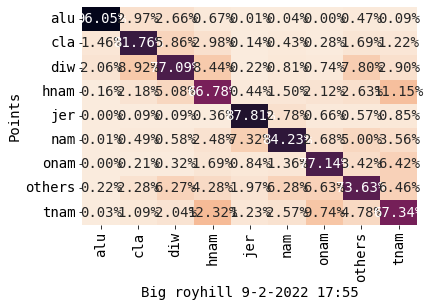

In [90]:
while True:
    print(1 * "\n")
    number_to_restrict = input(
        "Insert N to see a confusion matrix of top N domains (Confusion matrix including all domains will be stored as Entire_Matrix.png): "
    )
    try:
        number_to_restrict = int(number_to_restrict)
        if (
            number_to_restrict < 0
        ):  # if not a positive int print message and ask for input again
            print("Sorry, input must be a positive integer, try again")
            continue
        break
    except ValueError:
        print("That's not an integer, try again!")

# Feature to display first N elemnts only on confusion matrix

sub0_domains_not_needed, sub0_domain_counts = np.unique(
    point_domains_wo_outliers, return_counts=True
)
sub0_values = np.sort(np.asarray((sub0_domains_not_needed, sub0_domain_counts)).T)
count_sort_ind = np.argsort(-sub0_domain_counts)
sub0_domains_not_needed = list(
    sub0_domains_not_needed[count_sort_ind[number_to_restrict:]]
)

sub1_domains_not_needed, sub1_domain_counts = np.unique(
    domains_of_blocks, return_counts=True
)
sub1_values = np.sort(np.asarray((sub1_domains_not_needed, sub1_domain_counts)).T)
count_sort_ind = np.argsort(-sub1_domain_counts)
sub1_domains_not_needed = list(
    sub1_domains_not_needed[count_sort_ind[number_to_restrict:]]
)

df2["point_domains_edited"] = pd.Series(point_domains_wo_outliers)
df2["point_domains_edited"] = df2["point_domains_edited"].replace(
    sub0_domains_not_needed, "others"
)
df2["block_domains_edited"] = pd.Series(domains_of_blocks)
df2["block_domains_edited"] = df2["block_domains_edited"].replace(
    sub1_domains_not_needed, "others"
)

# CONFUSION MATRIX FOR POINT TO BLOCK COMPARISON

point_confusion_matrix = pd.crosstab(
    df2["point_domains_edited"],
    df2["block_domains_edited"],
    rownames=["Points"],
    colnames=[block_model_name],
)
point_confusion_matrix = pd.DataFrame(point_confusion_matrix)

mt = cm.figure(0)
gn = sns.heatmap(
    (point_confusion_matrix) / (np.sum(point_confusion_matrix)),
    cbar_kws={},
    annot=True,
    fmt=".2%",
    cmap="rocket_r",
    cbar=False,
    xticklabels=True,
    yticklabels=True,
)

cm.show()
# Uncomment the lines below to generate a report.
# print(
#     metrics.classification_report(
#         df["Points Domain"], df["Block Domains"], labels=colour_names, zero_division=1
#     )
# )

CONFUSION MATRIX FOR POINT TO BLOCK COMPARISON

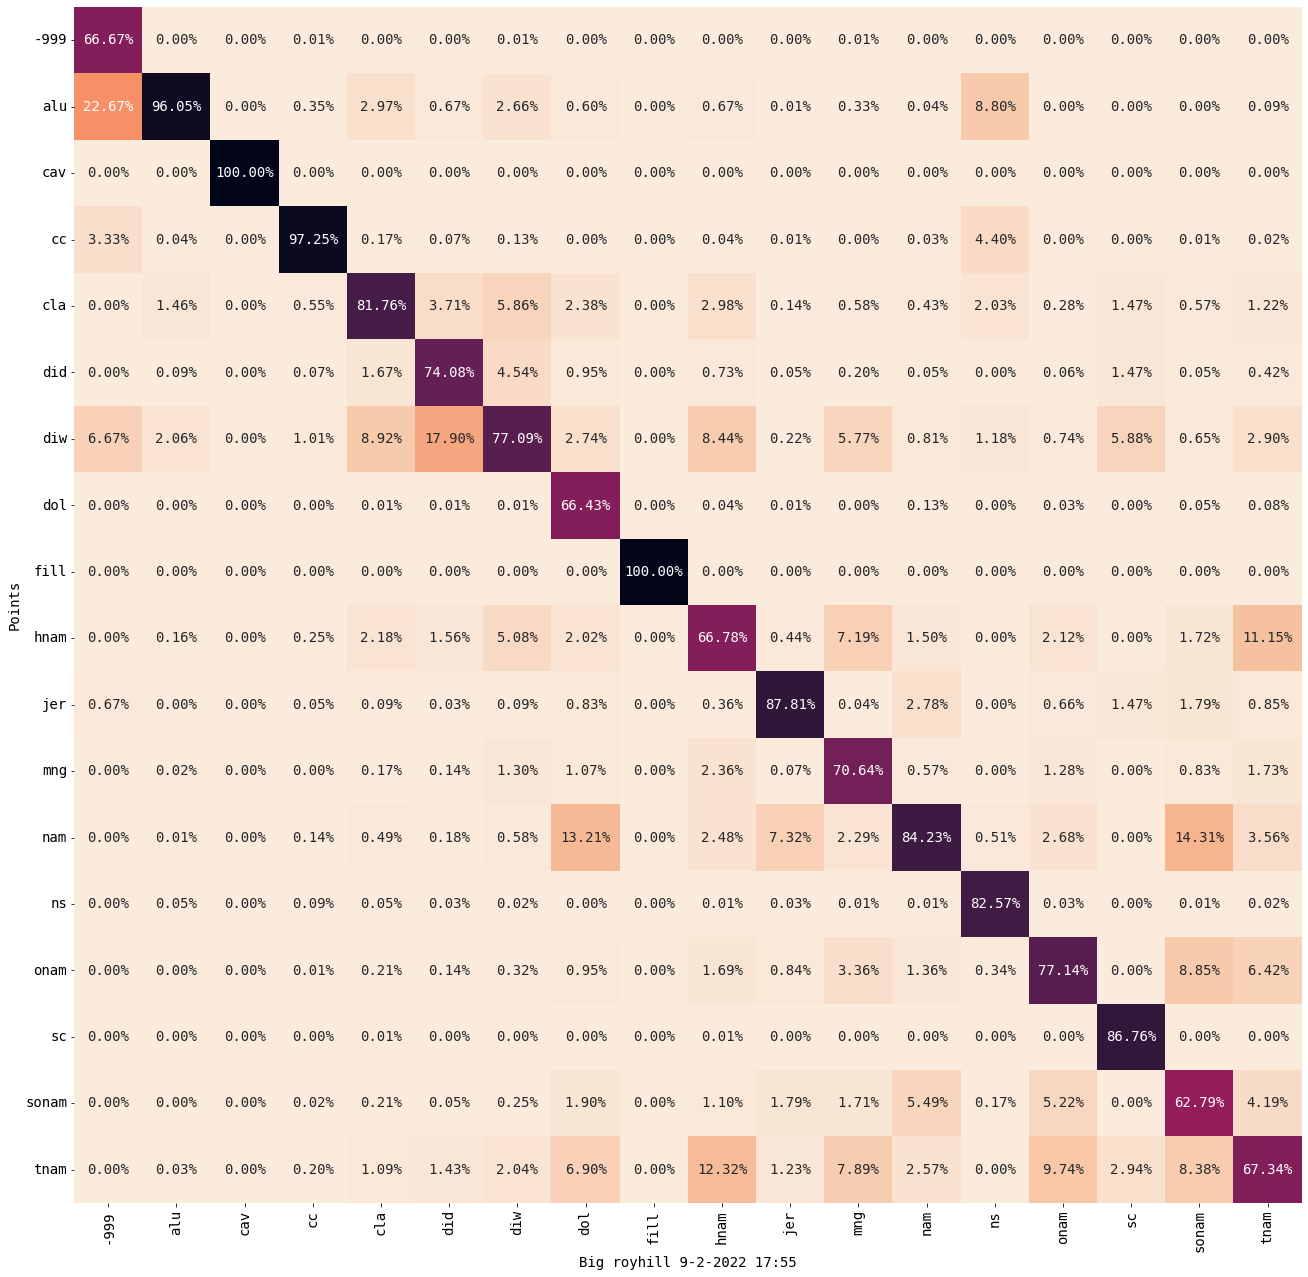

In [91]:
point_confusion_matrix = pd.crosstab(
    df2["Points Domain"],
    df2["Block Domains"],
    rownames=["Points"],
    colnames=[block_model_name],
)
point_confusion_matrix = pd.DataFrame(point_confusion_matrix)

mt = cm.figure(0)
gn = sns.heatmap(
    (point_confusion_matrix) / (np.sum(point_confusion_matrix)),
    cbar_kws={},
    annot=True,
    fmt=".2%",
    cmap="rocket_r",
    cbar=False,
    xticklabels=True,
    yticklabels=True,
)

mt.set_size_inches(22, 22)
mt.savefig("Entire_Matrix.png", dpi=100)
# Uncomment the lines below to generate a report.
# print(
#     metrics.classification_report(
#         df["Points Domain"], df["Block Domains"], labels=colour_names, zero_division=1
#     )
# )